In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df = pd.read_csv("/content/canteen_recommendation_dataset.csv"

)

In [38]:
print(df.shape)
print(df.columns)
df.head()

(700, 18)
Index(['user_id', 'item_id', 'item_name', 'category', 'price', 'datetime',
       'time_of_day', 'day_of_week', 'rating', 'calories', 'spicy_level',
       'popularity_score', 'purchase_count', 'last_purchased_days_ago',
       'user_age_group', 'user_gender', 'user_avg_spend', 'combo_preference'],
      dtype='object')


,user_id,item_id,item_name,category,price,datetime,time_of_day,day_of_week,rating,calories,spicy_level,popularity_score,purchase_count,last_purchased_days_ago,user_age_group,user_gender,user_avg_spend,combo_preference
0,U130,22,Rajma Chawal,Special,50,2024-08-22 10:58:00,Breakfast,Thursday,3,450,Medium,87,20,3,30s,F,62,Pizza+ColdDrink
1,U186,5,Maggi,Snacks,35,2025-08-02 13:58:00,Lunch,Saturday,3,300,Medium,50,8,12,Teen,M,42,Burger+Fries
2,U103,10,Coffee,Beverages,30,2024-01-06 14:42:00,Lunch,Saturday,4,100,Mild,79,17,8,30s,M,71,Burger+Fries
3,U140,17,Fried Rice,Noodles,50,2024-08-12 08:03:00,Breakfast,Monday,4,350,Medium,55,8,12,20s,M,45,Maggi+Chai
4,U124,18,Cheese Pizza,Pizza,65,2024-08-18 11:28:00,Lunch,Sunday,4,400,Mild,97,11,12,Teen,M,71,Burger+Fries


In [39]:
print(df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

user_id                    0
item_id                    0
item_name                  0
category                   0
price                      0
datetime                   0
time_of_day                0
day_of_week                0
rating                     0
calories                   0
spicy_level                0
popularity_score           0
purchase_count             0
last_purchased_days_ago    0
user_age_group             0
user_gender                0
user_avg_spend             0
combo_preference           0
dtype: int64
Duplicates: 0


In [40]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_name()
df['date'] = df['datetime'].dt.date


In [41]:
print(df.describe())


          item_id       price                       datetime      rating  \
count  700.000000  700.000000                            700  700.000000   
mean    12.404286   40.697143  2024-12-07 21:35:24.942857216    4.025714   
min      1.000000   15.000000            2024-01-01 12:02:00    3.000000   
25%      6.000000   30.000000            2024-06-27 19:57:00    3.000000   
50%     12.000000   40.000000            2024-12-04 00:55:00    4.000000   
75%     18.000000   50.000000            2025-05-18 11:04:45    5.000000   
max     24.000000   75.000000            2025-10-31 17:18:00    5.000000   
std      6.909655   15.583629                            NaN    0.807278   

         calories  popularity_score  purchase_count  last_purchased_days_ago  \
count  700.000000        700.000000      700.000000               700.000000   
mean   281.771429         75.394286       10.518571                 7.455714   
min     80.000000         50.000000        1.000000                 0.00000

In [42]:
df = df[(df['price'] > 0) & (df['calories'] > 0)]


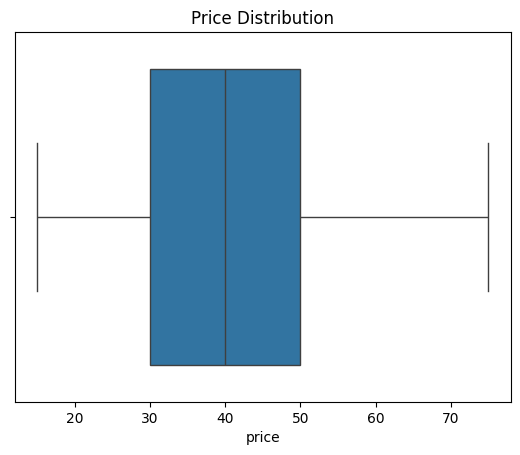

In [43]:
sns.boxplot(x=df['price'])
plt.title("Price Distribution")
plt.show()


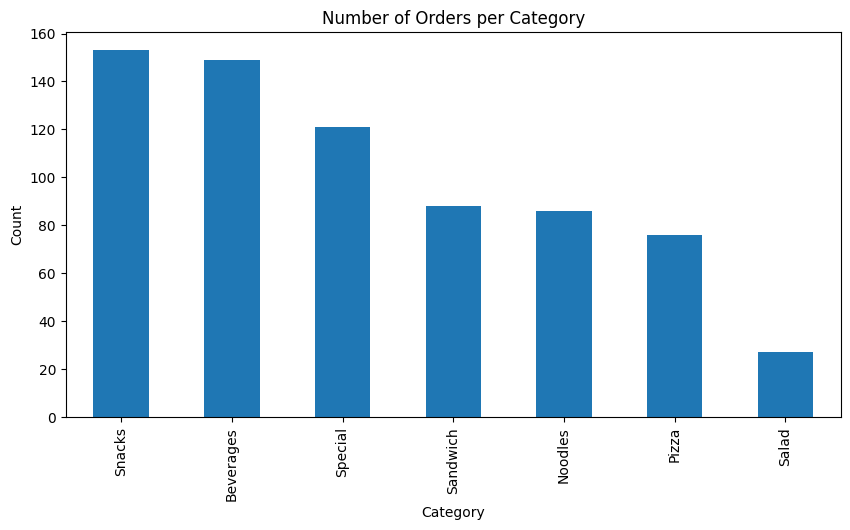

In [44]:
plt.figure(figsize=(10,5))
df['category'].value_counts().plot(kind='bar')
plt.title("Number of Orders per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


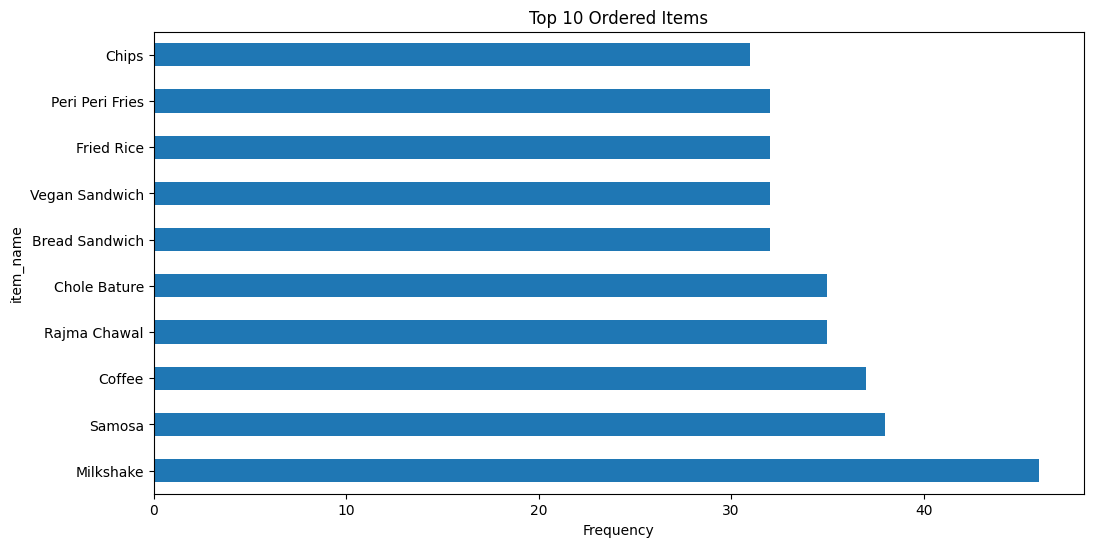

In [45]:
plt.figure(figsize=(12,6))
df['item_name'].value_counts().head(10).plot(kind='barh')
plt.title("Top 10 Ordered Items")
plt.xlabel("Frequency")
plt.show()


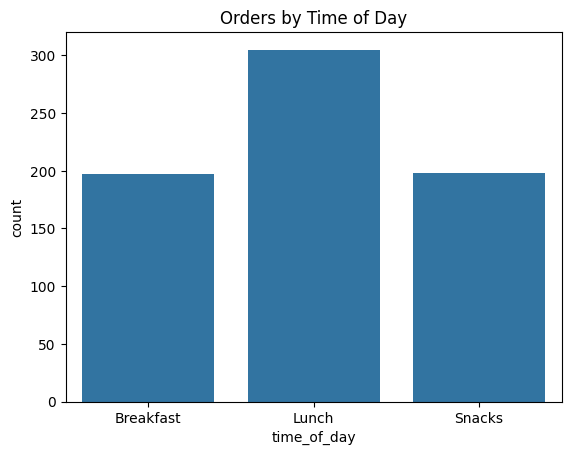

In [46]:
sns.countplot(x='time_of_day', data=df, order=['Breakfast', 'Lunch', 'Snacks'])
plt.title("Orders by Time of Day")
plt.show()


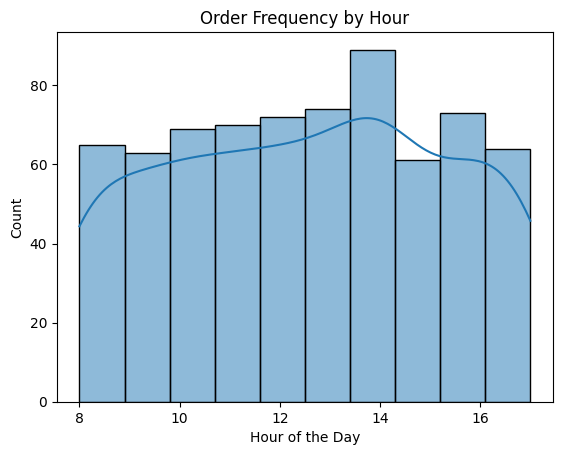

In [47]:
sns.histplot(df['hour'], bins=10, kde=True)
plt.title("Order Frequency by Hour")
plt.xlabel("Hour of the Day")
plt.show()


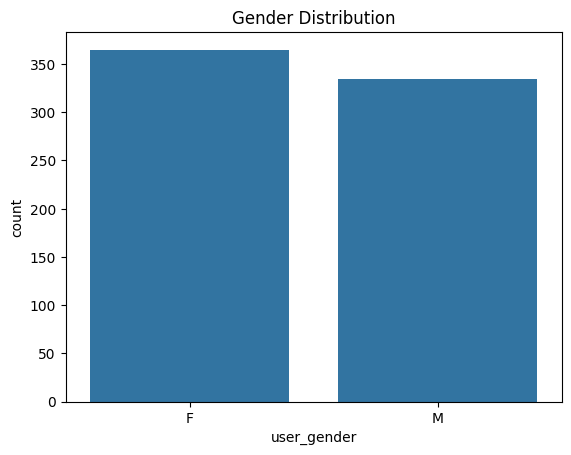

In [48]:
sns.countplot(x='user_gender', data=df)
plt.title("Gender Distribution")
plt.show()


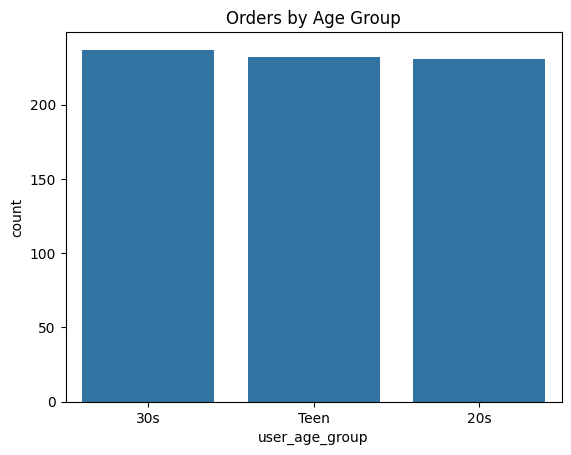

In [49]:
sns.countplot(x='user_age_group', data=df)
plt.title("Orders by Age Group")
plt.show()


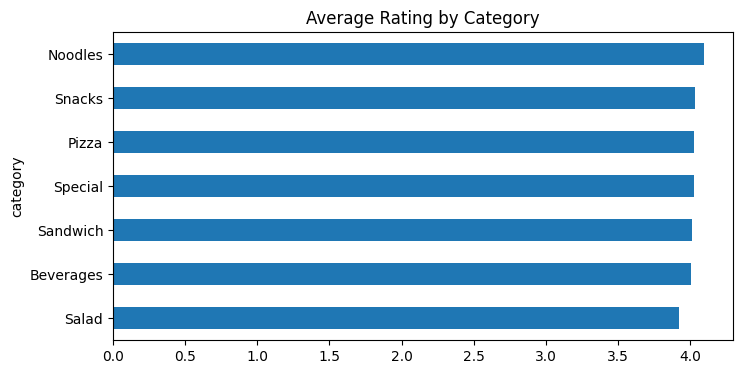

In [50]:
rating_by_category = df.groupby('category')['rating'].mean().sort_values()
rating_by_category.plot(kind='barh', figsize=(8,4))
plt.title("Average Rating by Category")
plt.show()


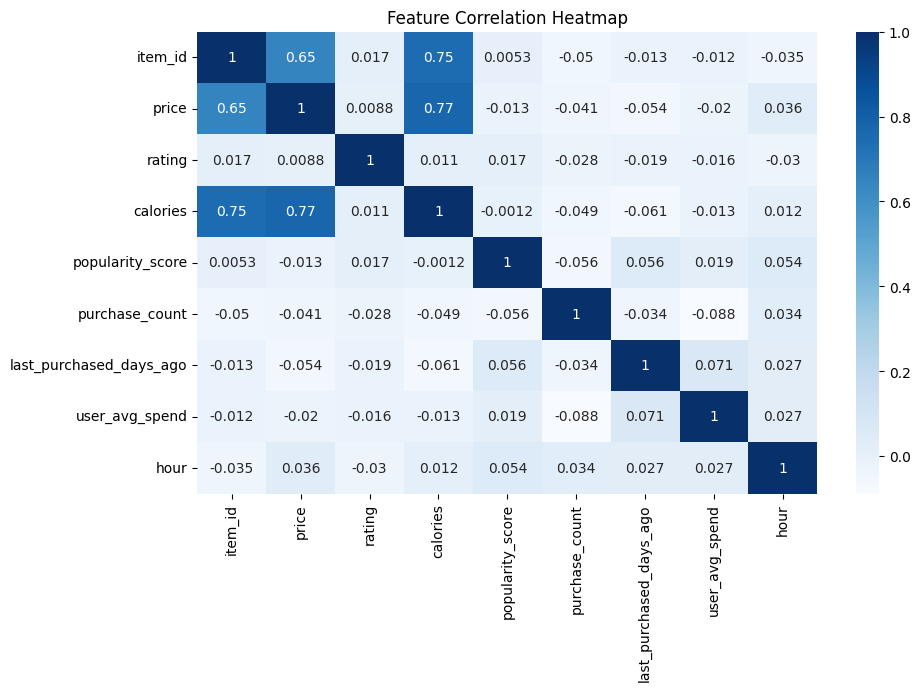

In [51]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')
plt.title("Feature Correlation Heatmap")
plt.show()


/tmp/ipython-input-162184488.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=popular_recent.values, y=popular_recent.index, palette='viridis')


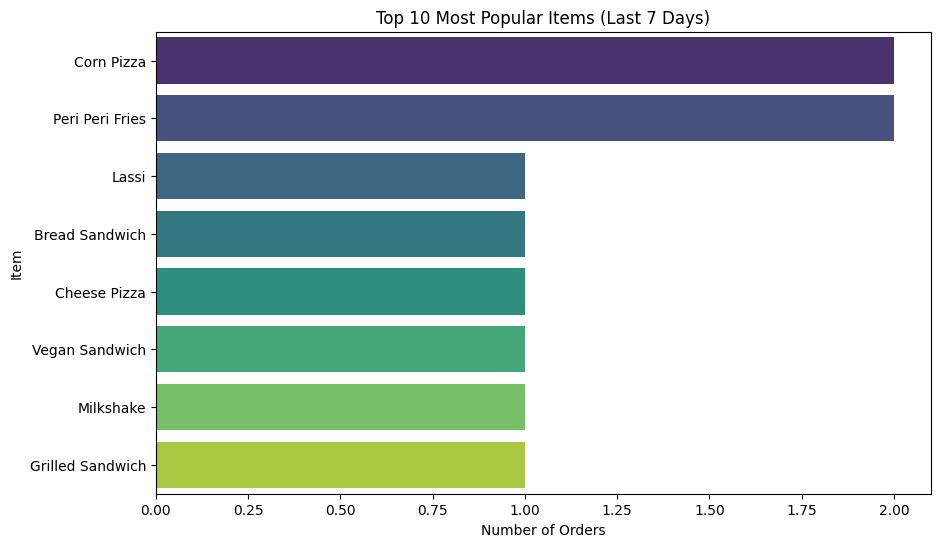

In [52]:
from datetime import datetime, timedelta
df['datetime'] = pd.to_datetime(df['datetime'])

end_date = df['datetime'].max()
start_date = end_date - timedelta(days=7)

recent_df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

popular_recent = recent_df['item_name'].value_counts().head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=popular_recent.values, y=popular_recent.index, palette='viridis')
plt.title("Top 10 Most Popular Items (Last 7 Days)")
plt.xlabel("Number of Orders")
plt.ylabel("Item")
plt.show()

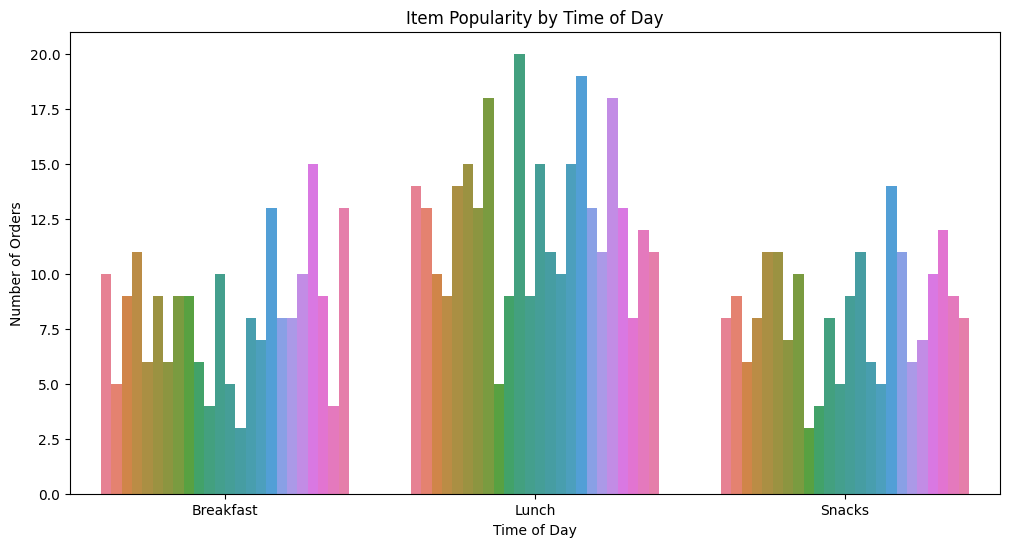

In [53]:
time_popularity = df.groupby(['time_of_day', 'item_name']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.barplot(x='time_of_day', y='count', hue='item_name', data=time_popularity)
plt.title("Item Popularity by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Orders")
plt.legend([],[], frameon=False)
plt.show()


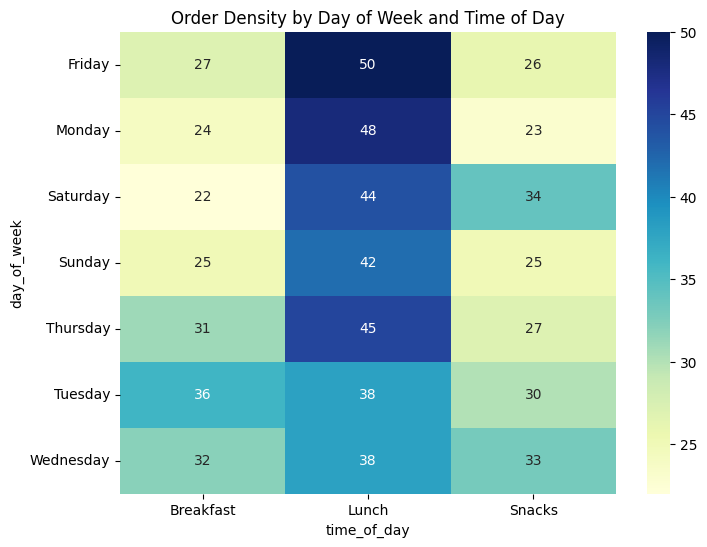

In [54]:
heatmap_data = df.groupby(['day_of_week', 'time_of_day']).size().unstack(fill_value=0)
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Order Density by Day of Week and Time of Day")
plt.show()


0 = breakfast
1 = lunch
2 = snacks

In [61]:
df.to_csv("canteen_data_final.csv", index=False)


Feature engineering


In [56]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['item_name', 'category', 'time_of_day', 'day_of_week', 'spicy_level',
                    'user_age_group', 'user_gender', 'combo_preference']

encoder = LabelEncoder()

for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])


In [57]:
from sklearn.preprocessing import MinMaxScaler

num_cols = ['price', 'calories', 'popularity_score', 'purchase_count',
            'last_purchased_days_ago', 'user_avg_spend']

scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [58]:
item_features = df[['item_id', 'category', 'price', 'calories', 'spicy_level', 'popularity_score']]
item_features = item_features.drop_duplicates(subset='item_id').set_index('item_id')


In [59]:
user_features = df[['user_id', 'user_age_group', 'user_gender', 'user_avg_spend']]


In [60]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(item_features)
similarity_df = pd.DataFrame(similarity_matrix,
                             index=item_features.index,
                             columns=item_features.index)


In [62]:
def recommend_items(item_id, n=5):
    similar_items = similarity_df[item_id].sort_values(ascending=False)[1:n+1]
    recommended_ids = similar_items.index
    return df[df['item_id'].isin(recommended_ids)][['item_name', 'category', 'price']]


In [63]:
recommend_items(item_id=5)


,item_name,category,price
0,19,6,0.583333
5,18,6,0.416667
19,5,6,0.583333
21,19,6,0.583333
23,1,3,0.333333
...,...,...,...
685,5,6,0.583333
688,11,4,0.416667
690,5,6,0.583333
694,5,6,0.583333


In [67]:

import os
import pickle

os.makedirs("models", exist_ok=True)

pickle.dump(similarity_df, open("models/item_similarity.pkl", "wb"))

